<a href="https://colab.research.google.com/github/yungnien/Springboard/blob/master/capstone/prototype_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary

# STEP 1 :  load Data and install Lib

this section utilize the similar structure as the earlier submission, a quick data clean up has been performed and the data been saved for later reclaim

In [0]:
!pip install nltk
!pip install contractions
!pip install textsearch

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 
from joblib import dump, load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CPU times: user 1.1 s, sys: 216 ms, total: 1.32 s
Wall time: 2.67 s


In [0]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def report(y, predicted):
    target_names = ['Sincere', 'Insincere']
        
    #classification_report 
    report = classification_report(y, predicted, target_names = target_names)
    print(report)
    
    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt = 'd')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
def plot_roc(y, predicted):
    #roc curve
    fpr, tpr, thresholds = roc_curve(y, predicted, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, thresholds1 = roc_curve(y, 1- predicted, pos_label = 0)
    roc_auc1 = auc(fpr1, tpr1)

    plt.figure()
    plt.plot(fpr, tpr, color ='blue', lw = 1, label = 'ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot(fpr1, tpr1, color ='red', lw = 1, label = 'ROC curve for insincere (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color ='black', lw = 1, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")
    plt.show()

In [0]:
%%time

import pandas as pd
train_path = '/content/gdrive/My Drive/data/'
train_data = pd.read_csv(train_path+'train.csv')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306122
CPU times: user 2.59 s, sys: 210 ms, total: 2.8 s
Wall time: 2.88 s


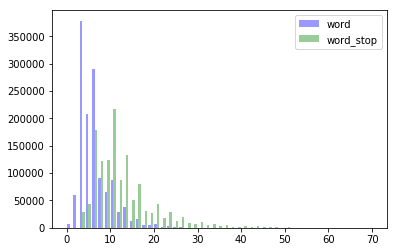

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('seaborn-deep')
bins = np.linspace(0, 70, 50)
colors = ['b','g']

plt.hist([train_data['word_count'], train_data['word_count_stopword']], bins, color=colors, alpha=0.4, label=['word','word_stop'])
plt.legend(loc='upper right')
plt.show()

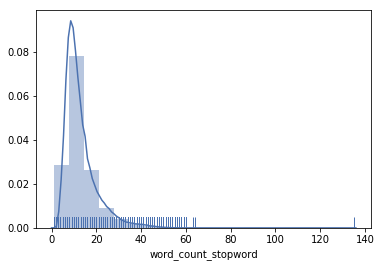

In [0]:
sns.distplot(train_data['word_count_stopword'], bins=20, kde=True, rug=True)

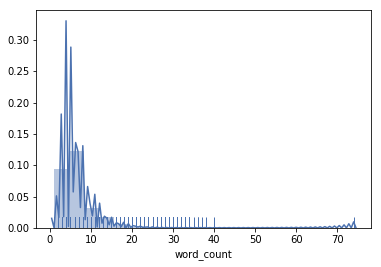

In [0]:
sns.distplot(train_data['word_count'], bins=20, kde=True, rug=True)

In [0]:
%%time

train_data['origin'] = train_data['question_text']
train_data['question_text_stopword'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character)
train_data['question_text'] = train_data['question_text_stopword'].apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['question_text_lemma_stopword'] = train_data['question_text_stopword'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data['word_count_stopword'] = train_data['question_text_lemma_stopword'].apply(lambda x: len(str(x).split()))

train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
print(train_data.head())

dump(train_data, train_path+'train_data.sav')

Training data set: 1306020
   index                   qid  ... word_count  word_count_stopword
0      0  00002165364db923c7e6  ...          6                   13
1      1  000032939017120e6e44  ...          7                   16
2      2  0000412ca6e4628ce2cf  ...          7                   10
3      3  000042bf85aa498cd78e  ...          6                    9
4      4  0000455dfa3e01eae3af  ...          7                   15

[5 rows x 11 columns]
CPU times: user 1h 12min 21s, sys: 2min 39s, total: 1h 15min
Wall time: 1h 15min 7s


#STEP 2 : DNN Model Using Keras API
for DNN algorithm, using the general data to prepare data and create model

###STEP 2.1  Data Preparation

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, Dropout, Activation
from tensorflow.python.keras import metrics
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer

num_words = 5000 
# due to limit on memory, number of words and layer of DNN is limited

In [0]:
from joblib import dump, load

train_path = '/content/gdrive/My Drive/data/'
train_data = load(train_path+'train_data.sav')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [0]:
tokenizer = Tokenizer(num_words=num_words)

In [0]:
%%time
tokenizer.fit_on_texts(train_data['question_text_lemma_stopword'])

CPU times: user 25.8 s, sys: 60.9 ms, total: 25.9 s
Wall time: 25.9 s


In [0]:
dump(tokenizer, train_path+'tokenizer_keras_dnn.sav')

['/content/gdrive/My Drive/data/tokenizer_keras_dnn.sav']

In [0]:
%%time

train_text = train_data['question_text_lemma_stopword']
train_target = train_data['target']

dump(train_text, train_path+'train_text_keras_dnn.sav')
dump(train_target, train_path+'target_keras_dnn.sav')

CPU times: user 1.22 s, sys: 180 ms, total: 1.4 s
Wall time: 2.42 s


###STEP 2.2 DNN Model 

In [0]:
%%time

from joblib import dump, load

train_path = '/content/gdrive/My Drive/data/'
train_target =load(train_path +'target_keras_dnn.sav')
train_text = load(train_path +'train_post_pad_keras_dnn.sav')
tokenizer = load(train_path +'tokenizer_keras_dnn.sav')

CPU times: user 4.23 s, sys: 504 ms, total: 4.74 s
Wall time: 5.67 s


In [0]:
%%time

from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold  = train_test_split(train_text, train_target, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = train_target)
X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, 
                                                     train_size = 0.9, test_size = 0.1,  
                                                     random_state = 42, stratify = y_train)
X_train, X_small, y_train, y_small  = train_test_split(X_train, y_train, 
                                                       train_size = 0.9, test_size = 0.1,  
                                                       random_state = 42, stratify = y_train)
X_large, X_mid, y_large, y_mid  = train_test_split(X_train, y_train, 
                                                   train_size = 0.7, test_size = 0.3,  
                                                   random_state = 42, stratify = y_train)

print(len(X_hold),len(X_test), len(X_small), len(X_mid), len(X_large), len(train_text))

261204 104482 94034 253890 592410 1306020
CPU times: user 2.9 s, sys: 195 ms, total: 3.1 s
Wall time: 3.14 s


In [0]:
X_test  = tokenizer.texts_to_matrix(X_test, mode='count')

dump(X_test, train_path+'X_test_keras_dnn.sav')
dump(y_test, train_path+'y_test_keras_dnn.sav')

['/content/gdrive/My Drive/data/y_test_keras_dnn.sav']

In [0]:
X_hold  = tokenizer.texts_to_matrix(X_hold, mode='count')

dump(X_hold, train_path+'X_hold_keras_dnn.sav')
dump(y_hold, train_path+'y_hold_keras_dnn.sav')

['/content/gdrive/My Drive/data/y_hold_keras_dnn.sav']

In [0]:
X_small  = tokenizer.texts_to_matrix(X_small, mode='count')

dump(X_small, train_path+'X_small_keras_dnn.sav')
dump(y_small, train_path+'y_small_keras_dnn.sav')

['/content/gdrive/My Drive/data/y_small_keras_dnn.sav']

In [0]:
from joblib import dump, load

train_path = '/content/gdrive/My Drive/data/'
X_small =load(train_path +'X_small_keras_dnn.sav')
y_small = load(train_path +'y_small_keras_dnn.sav')

In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)
model.add(Dense(256, input_shape=(num_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               1280256   
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [0]:
%%time
history =  model.fit(X_small, y_small, validation_split=0.1, epochs=5, batch_size=500)


Train on 84630 samples, validate on 9404 samples
Epoch 1/5
84630/84630 [==============================] - 4s 53us/sample - loss: 0.2014 - auc_2: 0.8082 - acc: 0.9355 - val_loss: 0.1469 - val_auc_2: 0.9184 - val_acc: 0.9381
Epoch 2/5
84630/84630 [==============================] - 4s 51us/sample - loss: 0.1325 - auc_2: 0.9320 - acc: 0.9466 - val_loss: 0.1403 - val_auc_2: 0.9206 - val_acc: 0.9473
Epoch 3/5
84630/84630 [==============================] - 4s 51us/sample - loss: 0.1145 - auc_2: 0.9509 - acc: 0.9551 - val_loss: 0.1416 - val_auc_2: 0.9163 - val_acc: 0.9469
Epoch 4/5
84630/84630 [==============================] - 4s 50us/sample - loss: 0.0986 - auc_2: 0.9639 - acc: 0.9632 - val_loss: 0.1459 - val_auc_2: 0.9135 - val_acc: 0.9482
Epoch 5/5
84630/84630 [==============================] - 4s 50us/sample - loss: 0.0815 - auc_2: 0.9743 - acc: 0.9702 - val_loss: 0.1632 - val_auc_2: 0.9035 - val_acc: 0.9472
CPU times: user 21.5 s, sys: 1.53 s, total: 23 s
Wall time: 22.2 s


In [0]:
plot_history(history)

In [0]:
train_path = '/content/gdrive/My Drive/data/'
model.save(train_path+'model_keras_dnn.h5')

In [0]:
from joblib import dump, load

train_path = '/content/gdrive/My Drive/data/'
X_hold =load(train_path +'X_hold_keras_dnn.sav')
y_hold = load(train_path +'y_hold_keras_dnn.sav')

In [0]:
%%time
result = model.evaluate(X_hold, y_hold)

261204/261204 [==============================] - 24s 93us/sample - loss: 0.1642 - auc: 0.8991 - acc: 0.9491
CPU times: user 27.9 s, sys: 2.58 s, total: 30.5 s
Wall time: 24.5 s


In [0]:
print("Accuracy: {0:.2%}".format(result[2]))
print("AUC: {0:.2%}, ".format(result[1]))

In [0]:
predicted = model.predict(X_hold)
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])

In [0]:

report(y_hold, cls_pred)
plot_roc(y_hold, predicted)


Accuracy: 94.91%
AUC: 89.91%


#STEP 3 : RNN (LSTM) Model Using Keras API
for RNN algorithm, using the general data to prepare data and create model

###STEP 3.1  Data Preparation

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras import metrics
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
from joblib import dump, load

train_path = '/content/gdrive/My Drive/data/'
train_data = load(train_path+'train_data.sav')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [0]:
num_words = 10000
max_tokens = 30
tokenizer = Tokenizer(num_words=num_words)

In [0]:
%%time
tokenizer.fit_on_texts(train_data['question_text_lemma_stopword'])

CPU times: user 26.4 s, sys: 39.8 ms, total: 26.4 s
Wall time: 26.5 s


In [0]:
len(tokenizer.word_index)

225357

In [0]:
train_data['question_text_tokens'] = tokenizer.texts_to_sequences(train_data['question_text_lemma_stopword'])

In [0]:
num_tokens = [len(tokens) for tokens in train_data['question_text_tokens']]
num_tokens = np.array(num_tokens)


In [0]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9669423132876985

In [0]:
pad = 'pre'

In [0]:
%%time
train_data['train_tokens_pre_pad'] = pad_sequences(train_data['question_text_tokens'], maxlen=max_tokens, padding=pad, truncating=pad).tolist()

CPU times: user 9.81 s, sys: 350 ms, total: 10.2 s
Wall time: 10.2 s


In [0]:
pad = 'post'

In [0]:
%%time
train_data['train_tokens_post_pad'] = pad_sequences(train_data['question_text_tokens'], maxlen=max_tokens, padding=pad, truncating=pad).tolist()

CPU times: user 8.79 s, sys: 337 ms, total: 9.13 s
Wall time: 9.13 s


In [0]:
%%time

from joblib import dump, load

dump(train_data, train_path+'train_data_with_token.sav')
dump(tokenizer, train_path+'tokenizer_keras.sav')

CPU times: user 26.5 s, sys: 3.06 s, total: 29.6 s
Wall time: 36.9 s


In [0]:
%%time

train_post_pad = train_data['train_tokens_post_pad']
train_pre_pad = train_data['train_tokens_pre_pad']
train_target = train_data['target']

dump(train_post_pad, train_path+'train_post_pad_keras.sav')
dump(train_pre_pad, train_path+'train_pre_pad_keras.sav')
dump(train_target, train_path+'target_keras.sav')

CPU times: user 6.56 s, sys: 371 ms, total: 6.93 s
Wall time: 8.8 s


In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    # Concatenate all words.
    text = " ".join(words)
    return text

In [0]:
print(train_data['origin'][1])
print(train_data['question_text_lemma_stopword'][1])
print(train_data['question_text_tokens'][1])
print(train_data['train_tokens_pre_pad'][1])
print(train_data['train_tokens_post_pad'][1])
print(tokens_to_string(train_data['train_tokens_pre_pad'][1]))
print(tokens_to_string(train_data['train_tokens_post_pad'][1]))

Do you have an adopted dog, how would you encourage people to adopt and not shop?
do you have an adopt dog how would you encourage people to adopt and not shop
[5, 13, 17, 28, 1660, 306, 10, 31, 13, 2474, 34, 6, 1660, 11, 20, 1360]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 13, 17, 28, 1660, 306, 10, 31, 13, 2474, 34, 6, 1660, 11, 20, 1360]
[5, 13, 17, 28, 1660, 306, 10, 31, 13, 2474, 34, 6, 1660, 11, 20, 1360, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
do you have an adopt dog how would you encourage people to adopt and not shop
do you have an adopt dog how would you encourage people to adopt and not shop


###STEP 3.2  RNN Model (pre padding and post padding)

In [70]:
%%time

from joblib import dump, load

train_path = '/content/gdrive/My Drive/data/'
train_target =load(train_path +'target_keras.sav')
train_text = load(train_path +'train_post_pad_keras.sav')
#train_text = load(train_path + 'train_pre_pad_keras.sav')

CPU times: user 6.25 s, sys: 607 ms, total: 6.86 s
Wall time: 6.89 s


In [71]:
%%time

from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold  = train_test_split(train_text, train_target, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = train_target)
X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, 
                                                     train_size = 0.9, test_size = 0.1,  
                                                     random_state = 42, stratify = y_train)
X_train, X_small, y_train, y_small  = train_test_split(X_train, y_train, 
                                                       train_size = 0.9, test_size = 0.1,  
                                                       random_state = 42, stratify = y_train)
X_large, X_mid, y_large, y_mid  = train_test_split(X_train, y_train, 
                                                   train_size = 0.7, test_size = 0.3,  
                                                   random_state = 42, stratify = y_train)

print(len(X_hold),len(X_test), len(X_small), len(X_mid), len(X_large), len(train_text))

261204 104482 94034 253890 592410 1306020
CPU times: user 3.27 s, sys: 61.7 ms, total: 3.33 s
Wall time: 3.33 s


In [0]:
embedding_size = 200
num_words = 10000
max_tokens = 30

In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)

In [0]:
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [75]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 200)           2000000   
_________________________________________________________________
gru_8 (GRU)                  (None, 30, 16)            10416     
_________________________________________________________________
gru_9 (GRU)                  (None, 30, 8)             600       
_________________________________________________________________
gru_10 (GRU)                 (None, 30, 8)             408       
_________________________________________________________________
gru_11 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 2,011,585
Trainable params: 2,011,585
Non-trainable params: 0
____________________________________________

In [76]:
%%time
history = model.fit(np.array(X_small.tolist()), y_small, validation_data=(np.array(X_test.tolist()),y_test), epochs=5, batch_size=500)


Train on 94034 samples, validate on 104482 samples
Epoch 1/5
94034/94034 [==============================] - 48s 506us/sample - loss: 0.2617 - auc_10: 0.5966 - acc: 0.9339 - val_loss: 0.2118 - val_auc_10: 0.8627 - val_acc: 0.9401
Epoch 2/5
94034/94034 [==============================] - 45s 481us/sample - loss: 0.1683 - auc_10: 0.8753 - acc: 0.9468 - val_loss: 0.1577 - val_auc_10: 0.8990 - val_acc: 0.9471
Epoch 3/5
94034/94034 [==============================] - 45s 477us/sample - loss: 0.1320 - auc_10: 0.9174 - acc: 0.9564 - val_loss: 0.1445 - val_auc_10: 0.8967 - val_acc: 0.9497
Epoch 4/5
94034/94034 [==============================] - 45s 476us/sample - loss: 0.1116 - auc_10: 0.9302 - acc: 0.9629 - val_loss: 0.1455 - val_auc_10: 0.9074 - val_acc: 0.9461
Epoch 5/5
94034/94034 [==============================] - 45s 477us/sample - loss: 0.0965 - auc_10: 0.9392 - acc: 0.9695 - val_loss: 0.1554 - val_auc_10: 0.8984 - val_acc: 0.9463
CPU times: user 5min 27s, sys: 19.4 s, total: 5min 47s
Wall

In [77]:
%%time
result = model.evaluate(np.array(X_hold.tolist()), y_hold)

261204/261204 [==============================] - 580s 2ms/sample - loss: 0.1544 - auc_10: 0.8986 - acc: 0.9465
CPU times: user 13min 57s, sys: 1min 4s, total: 15min 2s
Wall time: 9min 41s


In [78]:
%%time

predicted = model.predict(np.array(X_hold.tolist()))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])

CPU times: user 13min 25s, sys: 51 s, total: 14min 16s
Wall time: 8min 32s


Accuracy: 94.65%
AUC: 89.86%, 
              precision    recall  f1-score   support

     Sincere       0.97      0.98      0.97    245044
   Insincere       0.58      0.47      0.52     16160

    accuracy                           0.95    261204
   macro avg       0.77      0.73      0.75    261204
weighted avg       0.94      0.95      0.94    261204



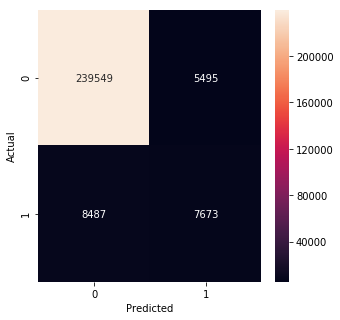

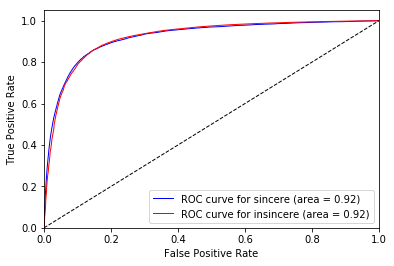

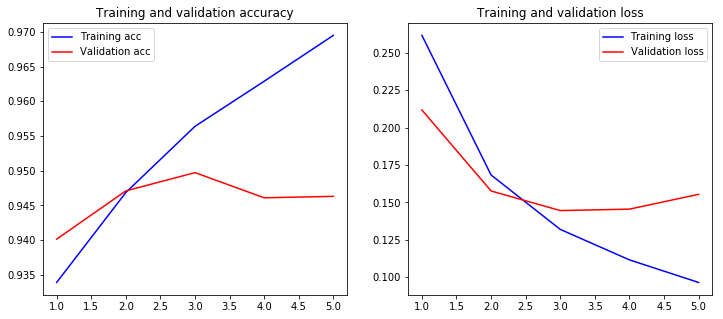

In [79]:
print("Accuracy: {0:.2%}".format(result[2]))
print("AUC: {0:.2%}, ".format(result[1]))
report(y_hold, cls_pred)
plot_roc(y_hold, predicted)
plot_history(history)

In [0]:
train_text = load(train_path + 'train_pre_pad_keras.sav')

In [81]:
%%time

from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold  = train_test_split(train_text, train_target, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = train_target)
X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, 
                                                     train_size = 0.9, test_size = 0.1,  
                                                     random_state = 42, stratify = y_train)
X_train, X_small, y_train, y_small  = train_test_split(X_train, y_train, 
                                                       train_size = 0.9, test_size = 0.1,  
                                                       random_state = 42, stratify = y_train)
X_large, X_mid, y_large, y_mid  = train_test_split(X_train, y_train, 
                                                   train_size = 0.7, test_size = 0.3,  
                                                   random_state = 42, stratify = y_train)

print(len(X_hold),len(X_test), len(X_small), len(X_mid), len(X_large), len(train_text))

261204 104482 94034 253890 592410 1306020
CPU times: user 3.14 s, sys: 102 ms, total: 3.24 s
Wall time: 3.24 s


In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)

In [0]:
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [84]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 200)           2000000   
_________________________________________________________________
gru_12 (GRU)                 (None, 30, 16)            10416     
_________________________________________________________________
gru_13 (GRU)                 (None, 30, 8)             600       
_________________________________________________________________
gru_14 (GRU)                 (None, 30, 8)             408       
_________________________________________________________________
gru_15 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 2,011,585
Trainable params: 2,011,585
Non-trainable params: 0
____________________________________________

In [85]:
%%time
history = model.fit(np.array(X_small.tolist()), y_small, validation_data=(np.array(X_test.tolist()),y_test), epochs=5, batch_size=500)

Train on 94034 samples, validate on 104482 samples
Epoch 1/5
94034/94034 [==============================] - 48s 506us/sample - loss: 0.3329 - auc_12: 0.5133 - acc: 0.9365 - val_loss: 0.2420 - val_auc_12: 0.7734 - val_acc: 0.9382
Epoch 2/5
94034/94034 [==============================] - 45s 474us/sample - loss: 0.1917 - auc_12: 0.8585 - acc: 0.9446 - val_loss: 0.1649 - val_auc_12: 0.8959 - val_acc: 0.9482
Epoch 3/5
94034/94034 [==============================] - 45s 478us/sample - loss: 0.1440 - auc_12: 0.9057 - acc: 0.9546 - val_loss: 0.1472 - val_auc_12: 0.9035 - val_acc: 0.9499
Epoch 4/5
94034/94034 [==============================] - 45s 475us/sample - loss: 0.1224 - auc_12: 0.9203 - acc: 0.9611 - val_loss: 0.1460 - val_auc_12: 0.8919 - val_acc: 0.9498
Epoch 5/5
94034/94034 [==============================] - 45s 474us/sample - loss: 0.1075 - auc_12: 0.9276 - acc: 0.9662 - val_loss: 0.1492 - val_auc_12: 0.8760 - val_acc: 0.9485
CPU times: user 5min 25s, sys: 20.7 s, total: 5min 46s
Wall

In [86]:
%%time
result = model.evaluate(np.array(X_hold.tolist()), y_hold)

261204/261204 [==============================] - 584s 2ms/sample - loss: 0.1494 - auc_12: 0.8763 - acc: 0.9480
CPU times: user 14min, sys: 1min 4s, total: 15min 5s
Wall time: 9min 44s


In [87]:
%%time
predicted = model.predict(np.array(X_hold.tolist()))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])


CPU times: user 13min 30s, sys: 52.5 s, total: 14min 22s
Wall time: 8min 35s


Accuracy: 94.80%
AUC: 87.63%, 
              precision    recall  f1-score   support

     Sincere       0.96      0.98      0.97    245044
   Insincere       0.61      0.44      0.51     16160

    accuracy                           0.95    261204
   macro avg       0.79      0.71      0.74    261204
weighted avg       0.94      0.95      0.94    261204



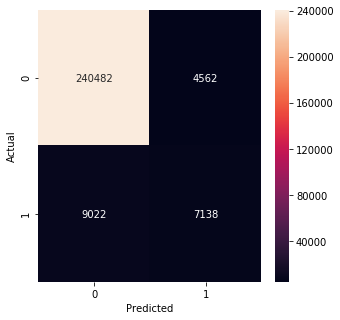

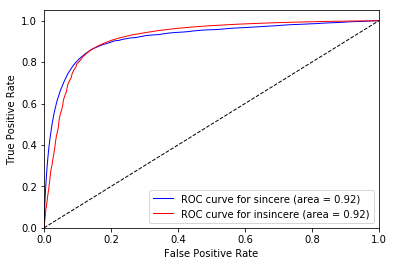

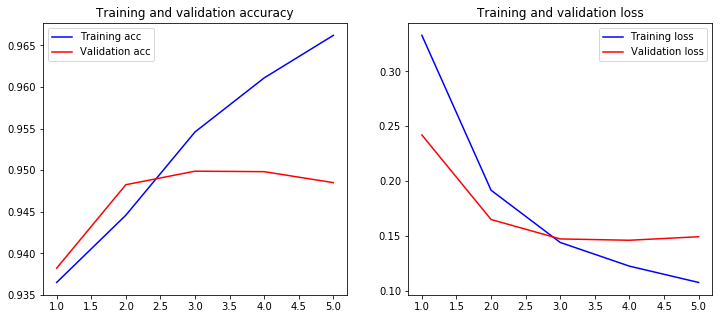

In [88]:
print("Accuracy: {0:.2%}".format(result[2]))
print("AUC: {0:.2%}, ".format(result[1]))
report(y_hold, cls_pred)
plot_roc(y_hold, predicted)
plot_history(history)

In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)

In [0]:
from tensorflow.python.keras.layers import LSTM

model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(LSTM(units=16, return_sequences=True))
model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [91]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 200)           2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 16)            13888     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 8)             800       
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 8)             544       
_________________________________________________________________
lstm_7 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 2,015,445
Trainable params: 2,015,445
Non-trainable params: 0
___________________________________________

In [92]:
%%time
history = model.fit(np.array(X_small.tolist()), y_small, validation_data=(np.array(X_test.tolist()),y_test), epochs=5, batch_size=500)

Train on 94034 samples, validate on 104482 samples
Epoch 1/5
94034/94034 [==============================] - 54s 574us/sample - loss: 0.3640 - auc_14: 0.4965 - acc: 0.9369 - val_loss: 0.2493 - val_auc_14: 0.5000 - val_acc: 0.9381
Epoch 2/5
94034/94034 [==============================] - 51s 538us/sample - loss: 0.2312 - auc_14: 0.6096 - acc: 0.9382 - val_loss: 0.1879 - val_auc_14: 0.8771 - val_acc: 0.9396
Epoch 3/5
94034/94034 [==============================] - 51s 540us/sample - loss: 0.1670 - auc_14: 0.8936 - acc: 0.9458 - val_loss: 0.1587 - val_auc_14: 0.8967 - val_acc: 0.9461
Epoch 4/5
94034/94034 [==============================] - 51s 538us/sample - loss: 0.1405 - auc_14: 0.9234 - acc: 0.9521 - val_loss: 0.1507 - val_auc_14: 0.8955 - val_acc: 0.9474
Epoch 5/5
94034/94034 [==============================] - 51s 538us/sample - loss: 0.1234 - auc_14: 0.9368 - acc: 0.9573 - val_loss: 0.1477 - val_auc_14: 0.9020 - val_acc: 0.9443
CPU times: user 6min, sys: 24 s, total: 6min 24s
Wall time:

In [93]:
%%time
result = model.evaluate(np.array(X_hold.tolist()), y_hold)

261204/261204 [==============================] - 620s 2ms/sample - loss: 0.1477 - auc_14: 0.9029 - acc: 0.9444
CPU times: user 14min 43s, sys: 1min 3s, total: 15min 46s
Wall time: 10min 20s


In [94]:
%%time 
predicted = model.predict(np.array(X_hold.tolist()))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])


CPU times: user 14min 4s, sys: 51.6 s, total: 14min 56s
Wall time: 9min 11s


Accuracy: 94.44%
AUC: 90.29%, 
              precision    recall  f1-score   support

     Sincere       0.97      0.97      0.97    245044
   Insincere       0.56      0.50      0.53     16160

    accuracy                           0.94    261204
   macro avg       0.76      0.74      0.75    261204
weighted avg       0.94      0.94      0.94    261204



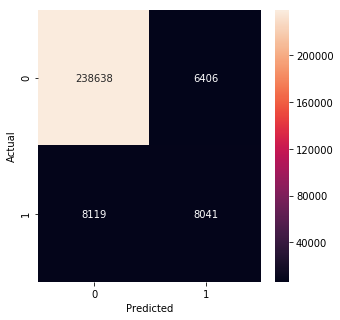

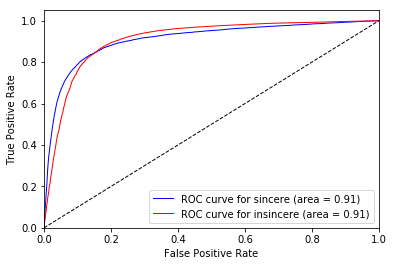

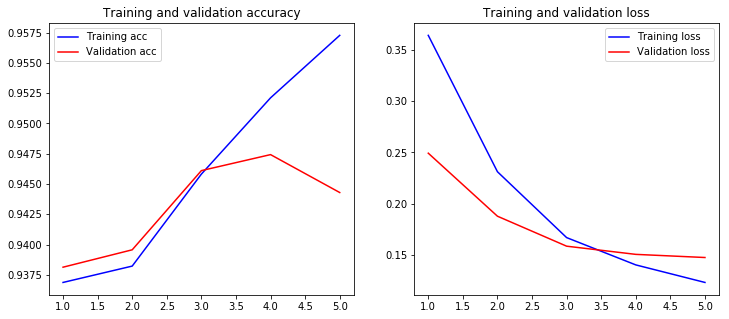

In [95]:
print("Accuracy: {0:.2%}".format(result[2]))
print("AUC: {0:.2%}, ".format(result[1]))
report(y_hold, cls_pred)
plot_roc(y_hold, predicted)
plot_history(history)

In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)

In [0]:
from tensorflow.python.keras.layers import Flatten, Activation, Dense, Embedding, Dropout

model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [98]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 200)           2000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               1536256   
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)             

In [99]:
%%time
history = model.fit(np.array(X_small.tolist()), y_small, validation_data=(np.array(X_test.tolist()),y_test), epochs=5, batch_size=500)

Train on 94034 samples, validate on 104482 samples
Epoch 1/5
94034/94034 [==============================] - 4s 42us/sample - loss: 0.1750 - auc_16: 0.8549 - acc: 0.9392 - val_loss: 0.1320 - val_auc_16: 0.9297 - val_acc: 0.9491
Epoch 2/5
94034/94034 [==============================] - 2s 20us/sample - loss: 0.1082 - auc_16: 0.9556 - acc: 0.9577 - val_loss: 0.1404 - val_auc_16: 0.9192 - val_acc: 0.9467
Epoch 3/5
94034/94034 [==============================] - 2s 20us/sample - loss: 0.0646 - auc_16: 0.9837 - acc: 0.9750 - val_loss: 0.1862 - val_auc_16: 0.8779 - val_acc: 0.9435
Epoch 4/5
94034/94034 [==============================] - 2s 20us/sample - loss: 0.0355 - auc_16: 0.9942 - acc: 0.9872 - val_loss: 0.2547 - val_auc_16: 0.8381 - val_acc: 0.9414
Epoch 5/5
94034/94034 [==============================] - 2s 20us/sample - loss: 0.0222 - auc_16: 0.9965 - acc: 0.9922 - val_loss: 0.3192 - val_auc_16: 0.8253 - val_acc: 0.9373
CPU times: user 17.6 s, sys: 1.68 s, total: 19.3 s
Wall time: 17.3 s


In [100]:
%%time
result = model.evaluate(np.array(X_hold.tolist()), y_hold)

261204/261204 [==============================] - 18s 70us/sample - loss: 0.3170 - auc_16: 0.8270 - acc: 0.9374
CPU times: user 23.3 s, sys: 1.71 s, total: 25.1 s
Wall time: 19.2 s


In [0]:
%%time 
predicted = model.predict(np.array(X_hold.tolist()))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])


In [0]:
print("Accuracy: {0:.2%}".format(result[2]))
print("AUC: {0:.2%}, ".format(result[1]))
report(y_hold, cls_pred)
plot_roc(y_hold, predicted)
plot_history(history)

In [0]:
plt.hist(predicted)
_ = plt.axvline(x=0.5, color='orange')
plt.show()

###STEP 4 : CNN Model Using Keras API
for CNN algorithm, using the data from step 3 and create model

In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)
drop_embed = 0.5
dropout = 0.5
n_conv = 256
k_conv = 3

In [0]:
from tensorflow.python.keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPool1D, Flatten, Dense, Dropout

model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPool1D())
#model.add(Flatten())
model.add(Dense(n_conv, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_conv/2, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [0]:
model.summary()

In [0]:
%%time
history = model.fit(np.array(X_small.tolist()), y_small, validation_data=(np.array(X_test.tolist()),y_test), epochs=5, batch_size=500)

In [0]:
%%time
result = model.evaluate(np.array(X_hold.tolist()), y_hold)

In [0]:
%%time 
predicted = model.predict(np.array(X_hold.tolist()))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])


In [0]:
print("Accuracy: {0:.2%}".format(result[2]))
print("AUC: {0:.2%}, ".format(result[1]))
report(y_hold, cls_pred)
plot_roc(y_hold, predicted)
plot_history(history)

###Reference

[Practical Text Classification With Python and Keras](https://realpython.com/python-keras-text-classification/)

[Getting started with Keras for NLP](https://nlpforhackers.io/keras-intro/)

[TensorFlow Tutorial #20 Natural Language Processing](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/20_Natural_Language_Processing.ipynb)

[Deep Learning for Natural Language Processing — Part III](https://medium.com/cityai/deep-learning-for-natural-language-processing-part-iii-96cfc6acfcc3)

[Introduction to 1D Convolutional Neural Networks for NLP](https://github.com/Tixierae/deep_learning_NLP/blob/master/cnn_imdb.ipynb)

[How to Develop an Multichannel CNN Model for Text Classification](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)
